<a href="https://colab.research.google.com/github/Asfilcnx3/Project4_BreastCancer/blob/main/BreastCancer_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification for the "Breast Cancer" dataset

## Using a simple RNN to classify different data on "Malignant" = 0 or "Benign" = 1

In [1]:
# Load all the librarys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean text

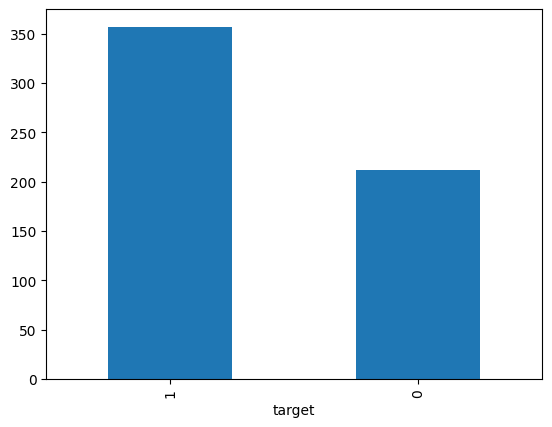

----------------------------------------


In [2]:
# Load the dataset to make a basic exploration.
breast_cancer = load_breast_cancer()
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df['target'] = breast_cancer.target
print(df.columns)
print("----"*10)

print(df.info())
print("----"*10)

print(df["target"].value_counts())
print("----"*10)

df["target"].value_counts().plot(kind="bar")
plt.show()
print("----"*10)

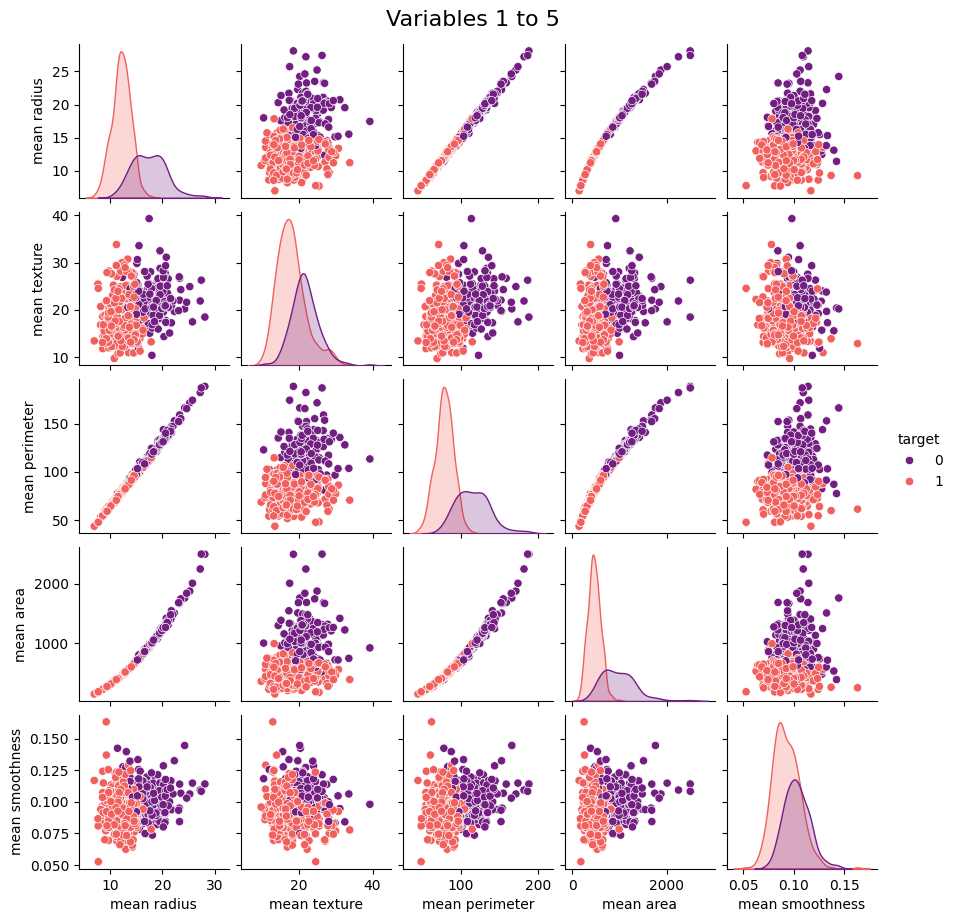

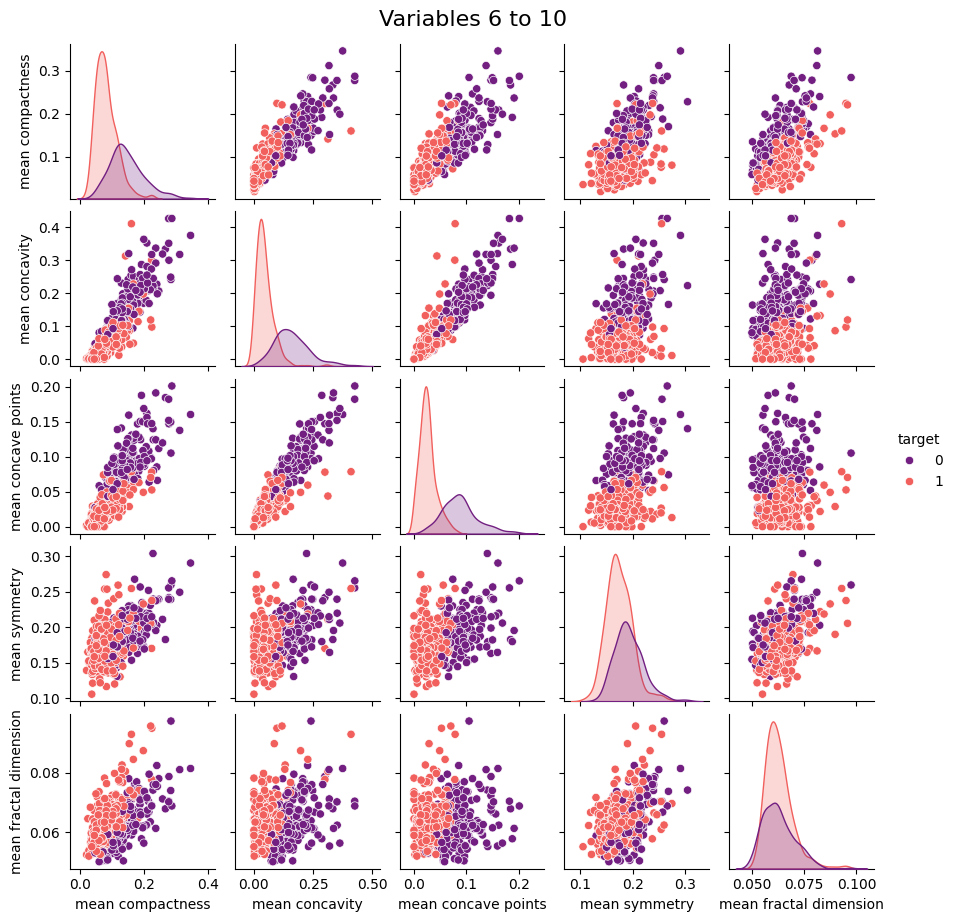

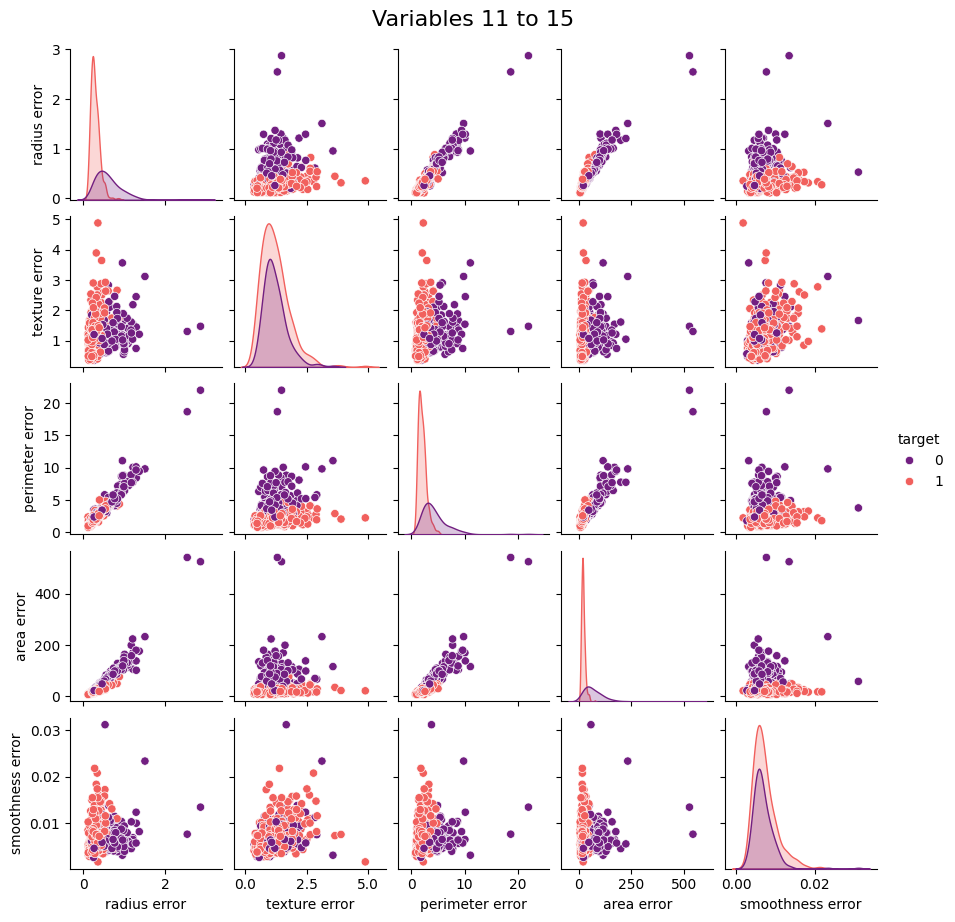

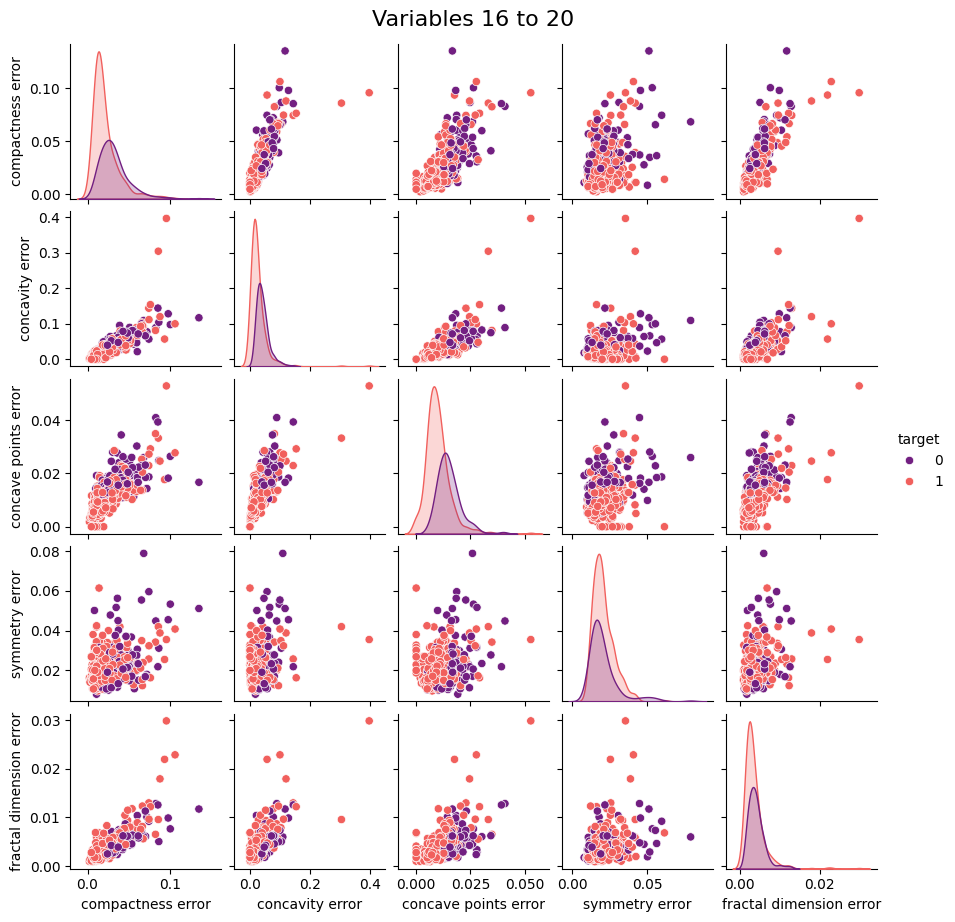

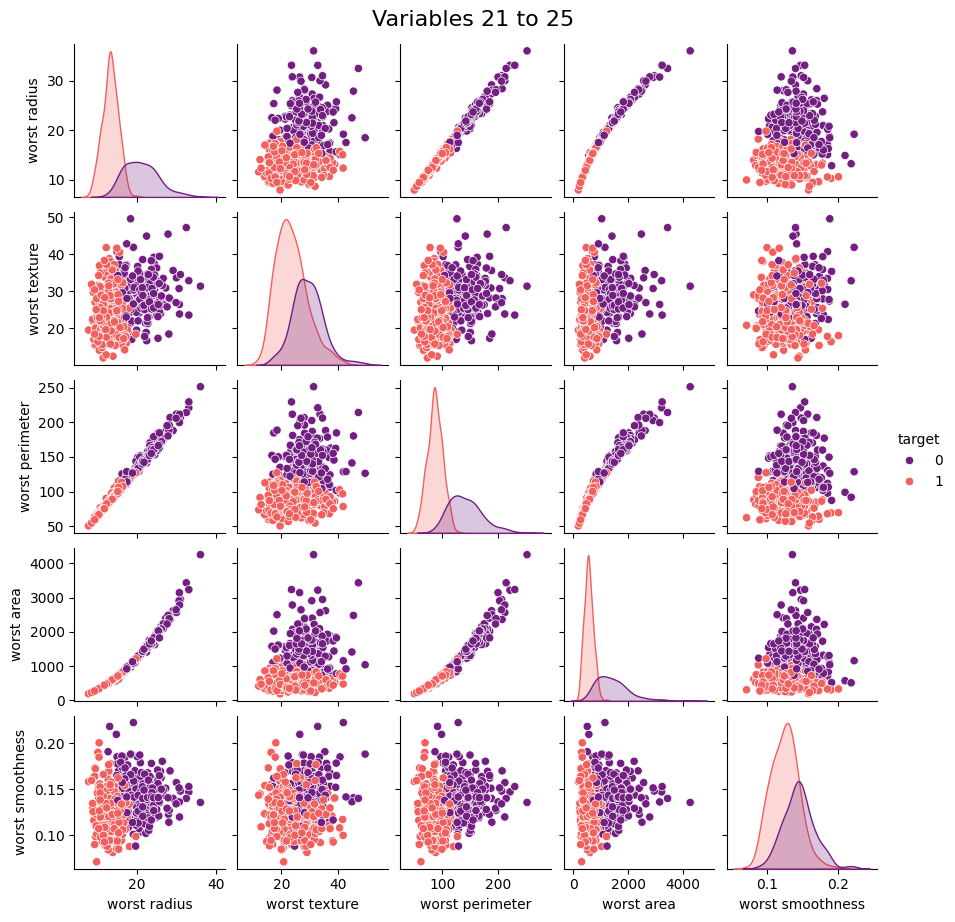

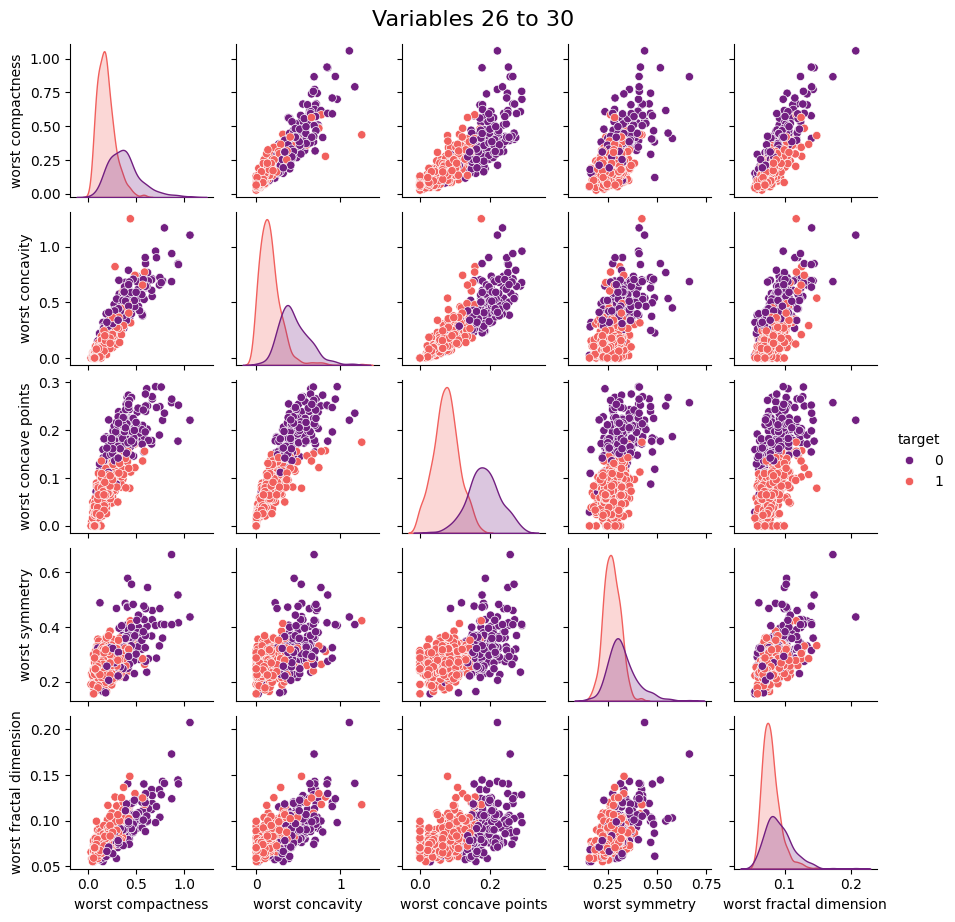

In [9]:
# Creating a loop to explore the relations between the data.
X = df.drop("target", axis=1)
y = df["target"]

cols_per_plot = 5
total_columns = X.shape[1]
num_plots = (total_columns + cols_per_plot - 1) // cols_per_plot

for idx in range(num_plots):
    start_col = idx * cols_per_plot
    end_col = min(start_col + cols_per_plot, total_columns)

    cols_block = X.columns[start_col:end_col].tolist() + ['target']

    sns.pairplot(df[cols_block], hue='target', palette='magma', height=1.8)
    plt.suptitle(f'Variables {start_col+1} to {end_col}', y=1.02, fontsize=16)
    plt.show()

In [6]:
# Making a "def" function to clean data

def prepare_all_data(X, y, scaler, train_size = 0.3, val_size = 0.5, random_state = 42):
  escaler = scaler()
  X_scaled = escaler.fit_transform(X)

  # Split X_train y y_train
  X_train, X_test_raw, y_train, y_test_raw = train_test_split(X_scaled, y, stratify = y, test_size = train_size, random_state = random_state)

  # Split Test and Validation
  X_test, X_val, y_test, y_val = train_test_split(X_test_raw, y_test_raw, stratify = y_test_raw, test_size = val_size, random_state = random_state)

  # Convert to a tensor
  X_train, y_train, X_valid, y_valid, X_test, y_test = map(
      lambda x: torch.tensor(x, dtype = torch.float32),
      (X_train, y_train.values, X_val, y_val.values, X_test, y_test.values)
  )

  return X_train, y_train, X_valid, y_valid, X_test, y_test

# Load function
X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_all_data(X, y, StandardScaler)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([398, 30])
torch.Size([398])
torch.Size([86, 30])
torch.Size([86])
torch.Size([85, 30])
torch.Size([85])


### Creating the NN with this arquitecture:
`Dense -> ReLU -> Dense -> ReLU -> Sigmoid Activation`

Epoch: 10, Loss: 0.682, Val Loss: 0.6763, Val Acc: 0.5000
----------------------------------------
Epoch: 20, Loss: 0.615, Val Loss: 0.6098, Val Acc: 0.8953
----------------------------------------
Epoch: 30, Loss: 0.5158, Val Loss: 0.5104, Val Acc: 0.9302
----------------------------------------
Epoch: 40, Loss: 0.3975, Val Loss: 0.3973, Val Acc: 0.9186
----------------------------------------
Epoch: 50, Loss: 0.2983, Val Loss: 0.3087, Val Acc: 0.9186
----------------------------------------
Epoch: 60, Loss: 0.226, Val Loss: 0.2465, Val Acc: 0.9186
----------------------------------------
Epoch: 70, Loss: 0.1772, Val Loss: 0.2057, Val Acc: 0.9186
----------------------------------------
Epoch: 80, Loss: 0.1443, Val Loss: 0.1785, Val Acc: 0.9186
----------------------------------------
Epoch: 90, Loss: 0.1215, Val Loss: 0.16, Val Acc: 0.9186
----------------------------------------
Epoch: 100, Loss: 0.1054, Val Loss: 0.147, Val Acc: 0.9302
----------------------------------------
Epoch

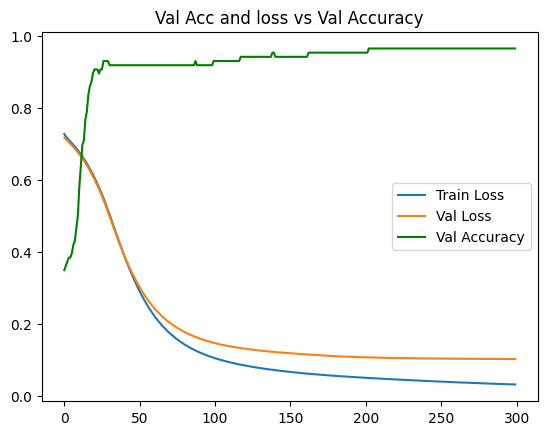

In [7]:
# Creating the Binary Classification NN
class BinaryClassification(nn.Module):
  def __init__(self):
    super(BinaryClassification, self).__init__()

    self.layer_1 = nn.Linear(30, 32)
    self.layer_2 = nn.Linear(32, 16)
    self.layer_3 = nn.Linear(16, 1)

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = torch.sigmoid(self.layer_3(x)) # Sigmoid to binary classification
    return x

# Creating the model and the params
model = BinaryClassification()
loss_fn = nn.BCELoss() # Using BCELoss
optimizer = optim.NAdam(model.parameters(), lr=0.001)

# Training Loop
epochs = 300
val_loss = []
val_accs = []
losses = []

for epoch in range(epochs):
  model.train()
  outputs= model(X_train)
  loss = loss_fn(outputs.squeeze(), y_train) # <- Using squeeze (BCELoss requeres it)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

  model.eval()
  with torch.no_grad():
    val_outputs = model(X_valid)
    val_loss_value = loss_fn(val_outputs.squeeze(), y_valid) # <- Using squeeze (BCELoss requeres it too)
    val_predicted = (val_outputs.squeeze() > 0.5).long()
    val_acc = accuracy_score(y_valid.numpy(), val_predicted.numpy())
    val_loss.append(val_loss_value.item())
    val_accs.append(val_acc)

  if (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch+1}, Loss: {round(loss.item(), 4)}, Val Loss: {round(val_loss_value.item(), 4)}, Val Acc: {val_acc:.4f}")
    print("----"*10)

# Visualize the validation accuracy and training loss
plt.plot(losses, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.plot(val_accs, label="Val Accuracy", color='green')
plt.title("Val Acc and loss vs Val Accuracy")
plt.legend()
plt.show()

Accuracy: 97.6471%
----------------------------------------


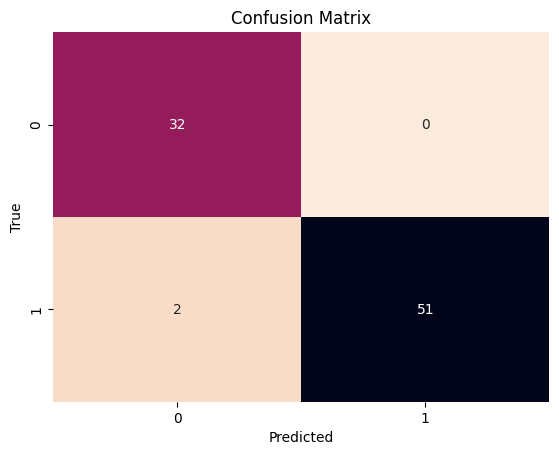

In [8]:
# Evaluate the testing set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = (outputs.squeeze() > 0.5).long() # use sequeeze
    acc = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f'Accuracy: {acc*100:.4f}%')
    print("----"*10)

# Creating a confusion matrix
cm = confusion_matrix(y_test.numpy(), predicted.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap="rocket_r", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()